## Dependencies

In [ ]:
!pip install transformers
!pip install pytorch-lightning
!pip install datasets
!pip install torchsummary
!pip install py7zr
!pip install rouge-score
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/req_command.py", line 241, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/commands/install.py", line 499, in run
    conflicts = self._determine_conflicts(to_inst

## Imports

In [ ]:

import torch
import numpy as np
import pandas as pd
from transformers import (
    T5ForConditionalGeneration,
    MT5ForConditionalGeneration,
    ByT5Tokenizer,
    PreTrainedTokenizer,
    T5TokenizerFast as T5Tokenizer,
    MT5TokenizerFast as MT5Tokenizer,
)
from transformers import AutoTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelWithLMHead, AutoTokenizer
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar

torch.cuda.empty_cache()
pl.seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.seed:Global seed set to 42


## Load Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("samsum")

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Data Processing

In [ ]:
train_df = dataset['train'].to_pandas()
validate_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

In [ ]:
train_df = train_df[["dialogue","summary"]]
test_df = test_df[["dialogue","summary"]]
validate_df = validate_df[["dialogue","summary"]]

In [ ]:
train_df['dialogue'] = "summarize: " + train_df['dialogue']
test_df['dialogue'] = "summarize: " + test_df['dialogue']
train_df = train_df.rename(columns={"summary":"target_text", "dialogue":"source_text"})
test_df = test_df.rename(columns={"summary":"target_text", "dialogue":"source_text"})
validate_df = validate_df.rename(columns={"summary":"target_text", "dialogue":"source_text"})

## Dataset Insights

In [ ]:
tiny_dataset = dataset['train']

In [ ]:
text_len = []
summary_len = []

In [ ]:
for i in range(len(tiny_dataset)):
    example = tiny_dataset[i]
    text_example = example['dialogue']
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    text_len.append(len(text_words))
    summary_example = example['summary']
    summary_example = summary_example.replace('\n','')
    summary_words = summary_example.split()
    summary_len.append(len(summary_words))

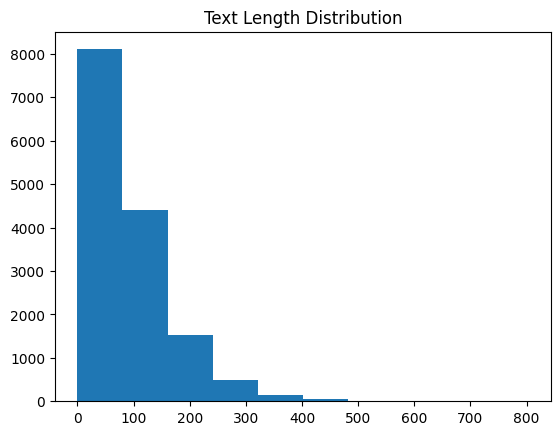

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(text_len)
plt.title('Text Length Distribution')
plt.show()

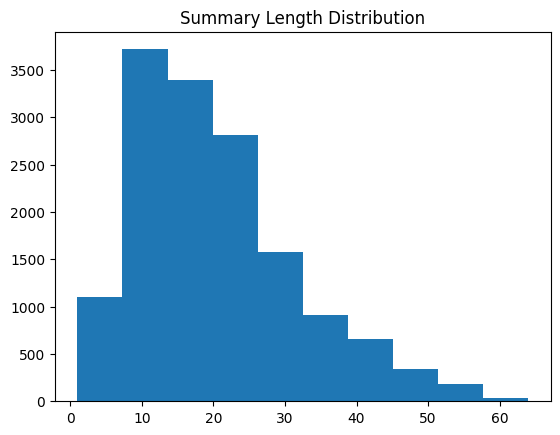

In [ ]:
plt.hist(summary_len)
plt.title('Summary Length Distribution')
plt.show()

In [ ]:
print("Longest length is:\n",train_df.source_text.str.len().max())

Longest length is:
 5503


Unzip model to load

In [ ]:
!unzip /content/drive/MyDrive/model-49.zip

Archive:  /content/drive/MyDrive/model-49.zip
   creating: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/
  inflating: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/tokenizer_config.json  
  inflating: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/spiece.model  
  inflating: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/pytorch_model.bin  
  inflating: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/tokenizer.json  
  inflating: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/config.json  
  inflating: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/special_tokens_map.json  


Load saved model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.load_model("t5","/content/content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135", use_gpu=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PyTorch Lightning Modules

In [ ]:
class PyTorchDataModule(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        source_max_token_len: int = 512,
        target_max_token_len: int = 512,
    ):
        """
        initiates a PyTorch Dataset Module for input data
        Args:
            data (pd.DataFrame): input pandas dataframe. Dataframe must have 2 column --> "source_text" and "target_text"
            tokenizer (PreTrainedTokenizer): a PreTrainedTokenizer (T5Tokenizer, MT5Tokenizer, or ByT5Tokenizer)
            source_max_token_len (int, optional): max token length of source text. Defaults to 512.
            target_max_token_len (int, optional): max token length of target text. Defaults to 512.
        """
        self.tokenizer = tokenizer
        self.data = data
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len

    def __len__(self):
        """ returns length of data """
        return len(self.data)

    def __getitem__(self, index: int):
        """ returns dictionary of input tensors to feed into T5"""

        data_row = self.data.iloc[index]
        source_text = data_row["source_text"]

        source_text_encoding = self.tokenizer(
            source_text,
            max_length=self.source_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )

        target_text_encoding = self.tokenizer(
            data_row["target_text"],
            max_length=self.target_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )

        labels = target_text_encoding["input_ids"]
        labels[
            labels == 0
        ] = -100  # to make sure we have correct labels for T5 text generation

        return dict(
            source_text_input_ids=source_text_encoding["input_ids"].flatten(),
            source_text_attention_mask=source_text_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=target_text_encoding["attention_mask"].flatten(),
        )


class LightningDataModule(pl.LightningDataModule):
    """ PyTorch Lightning data class """

    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        batch_size: int = 4,
        source_max_token_len: int = 512,
        target_max_token_len: int = 512,
        num_workers: int = 8,
    ):
        """
        initiates a PyTorch Lightning Data Module
        Args:
            train_df (pd.DataFrame): training dataframe. Dataframe must contain 2 columns --> "source_text" & "target_text"
            test_df (pd.DataFrame): validation dataframe. Dataframe must contain 2 columns --> "source_text" & "target_text"
            tokenizer (PreTrainedTokenizer): PreTrainedTokenizer (T5Tokenizer, MT5Tokenizer, or ByT5Tokenizer)
            batch_size (int, optional): batch size. Defaults to 4.
            source_max_token_len (int, optional): max token length of source text. Defaults to 512.
            target_max_token_len (int, optional): max token length of target text. Defaults to 512.
        """
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train_dataset = PyTorchDataModule(
            self.train_df,
            self.tokenizer,
            self.source_max_token_len,
            self.target_max_token_len,
        )
        self.test_dataset = PyTorchDataModule(
            self.test_df,
            self.tokenizer,
            self.source_max_token_len,
            self.target_max_token_len,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )


class LightningModel(pl.LightningModule):
    """ PyTorch Lightning Model class"""

    def __init__(
        self,
        tokenizer,
        model,
        outputdir: str = "outputs",
        save_only_last_epoch: bool = False,
    ):
        """
        initiates a PyTorch Lightning Model
        Args:
            tokenizer : T5/MT5/ByT5 tokenizer
            model : T5/MT5/ByT5 model
            outputdir (str, optional): output directory to save model checkpoints. Defaults to "outputs".
            save_only_last_epoch (bool, optional): If True, save just the last epoch else models are saved for every epoch
        """
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.outputdir = outputdir
        self.average_training_loss = None
        self.average_validation_loss = None
        self.save_only_last_epoch = save_only_last_epoch

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask,
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_size):
        input_ids = batch["source_text_input_ids"]
        attention_mask = batch["source_text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )

        self.log(
            "train_loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True
        )
        return loss

    def validation_step(self, batch, batch_size):
        input_ids = batch["source_text_input_ids"]
        attention_mask = batch["source_text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )

        self.log(
            "val_loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True
        )
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch["source_text_input_ids"]
        attention_mask = batch["source_text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

    def training_epoch_end(self, training_step_outputs):
        self.average_training_loss = np.round(
            torch.mean(torch.stack([x["loss"] for x in training_step_outputs])).item(),
            4,
        )
        path = f"{self.outputdir}/t5-epoch-{self.current_epoch}-train-loss-{str(self.average_training_loss)}-val-loss-{str(self.average_validation_loss)}"
        if self.save_only_last_epoch:
            if self.current_epoch == self.trainer.max_epochs - 1:
                self.tokenizer.save_pretrained(path)
                self.model.save_pretrained(path)
        else:
            self.tokenizer.save_pretrained(path)
            self.model.save_pretrained(path)

    def validation_epoch_end(self, validation_step_outputs):
        _loss = [x.cpu() for x in validation_step_outputs]
        self.average_validation_loss = np.round(
            torch.mean(torch.stack(_loss)).item(),
            4,
        )


class T5Model:

    def __init__(self) -> None:
        pass

    def from_pretrained(self, model_type="t5", model_name="t5-base") -> None:
        """
        loads T5 model for training/finetuning
        Args:
            model_type (str, optional): "t5" or "mt5" . Defaults to "t5".
            model_name (str, optional): exact model architecture name, "t5-base" or "t5-large". Defaults to "t5-base".
        """
        self.tokenizer = T5Tokenizer.from_pretrained(f"{model_name}")
        self.model = T5ForConditionalGeneration.from_pretrained(
            f"{model_name}", return_dict=True
        )

    def train(
        self,
        train_df: pd.DataFrame,
        eval_df: pd.DataFrame,
        source_max_token_len: int = 512,
        target_max_token_len: int = 512,
        batch_size: int = 8,
        max_epochs: int = 5,
        use_gpu: bool = True,
        outputdir: str = "outputs",
        early_stopping_patience_epochs: int = 0,  # 0 to disable early stopping feature
        precision=32,
        logger="default",
        dataloader_num_workers: int = 2,
        save_only_last_epoch: bool = False,
    ):
        """
        trains T5 model on custom dataset
        Args:
            train_df (pd.DataFrame): training datarame. Dataframe must have 2 column --> "source_text" and "target_text"
            eval_df ([type], optional): validation datarame. Dataframe must have 2 column --> "source_text" and "target_text"
            source_max_token_len (int, optional): max token length of source text. Defaults to 512.
            target_max_token_len (int, optional): max token length of target text. Defaults to 512.
            batch_size (int, optional): batch size. Defaults to 8.
            max_epochs (int, optional): max number of epochs. Defaults to 5.
            use_gpu (bool, optional): if True, model uses gpu for training. Defaults to True.
            outputdir (str, optional): output directory to save model checkpoints. Defaults to "outputs".
            early_stopping_patience_epochs (int, optional): monitors val_loss on epoch end and stops training, if val_loss does not improve after the specied number of epochs. set 0 to disable early stopping. Defaults to 0 (disabled)
            precision (int, optional): sets precision training - Double precision (64), full precision (32) or half precision (16). Defaults to 32.
            logger (pytorch_lightning.loggers) : any logger supported by PyTorch Lightning. Defaults to "default". If "default", pytorch lightning default logger is used.
            dataloader_num_workers (int, optional): number of workers in train/test/val dataloader
            save_only_last_epoch (bool, optional): If True, saves only the last epoch else models are saved at every epoch
        """
        self.data_module = LightningDataModule(
            train_df,
            eval_df,
            self.tokenizer,
            batch_size=batch_size,
            source_max_token_len=source_max_token_len,
            target_max_token_len=target_max_token_len,
            num_workers=dataloader_num_workers,
        )

        self.T5Model = LightningModel(
            tokenizer=self.tokenizer,
            model=self.model,
            outputdir=outputdir,
            save_only_last_epoch=save_only_last_epoch,
        )

        # add callbacks
        callbacks = [TQDMProgressBar(refresh_rate=5)]

        if early_stopping_patience_epochs > 0:
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.00,
                patience=early_stopping_patience_epochs,
                verbose=True,
                mode="min",
            )
            callbacks.append(early_stop_callback)

        # add gpu support
        gpus = 1 if use_gpu else 0

        # add logger
        loggers = True if logger == "default" else logger

        # prepare trainer
        trainer = pl.Trainer(
            logger=loggers,
            callbacks=callbacks,
            max_epochs=max_epochs,
            gpus=gpus,
            precision=precision,
            log_every_n_steps=1,
        )

        # fit trainer
        trainer.fit(self.T5Model, self.data_module)

    def load_model(
        self, model_type: str = "t5", model_dir: str = "outputs", use_gpu: bool = False
    ):
        """
        loads a checkpoint for inferencing/prediction
        Args:
            model_type (str, optional): Defaults to "t5".
            model_dir (str, optional): path to model directory. Defaults to "outputs".
            use_gpu (bool, optional): if True, model uses gpu for inferencing/prediction. Defaults to True.
        """
        self.model = T5ForConditionalGeneration.from_pretrained(f"{model_dir}")
        self.tokenizer = T5Tokenizer.from_pretrained(f"{model_dir}")

        if use_gpu:
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
            else:
                raise "exception ---> no gpu found. set use_gpu=False, to use CPU"
        else:
            self.device = torch.device("cpu")

        self.model = self.model.to(self.device)

    def predict(
        self,
        source_text: str,
        max_length: int = 512,
        num_return_sequences: int = 1,
        num_beams: int = 2,
        top_k: int = 50,
        top_p: float = 0.95,
        do_sample: bool = True,
        repetition_penalty: float = 2.5,
        length_penalty: float = 1.0,
        early_stopping: bool = True,
        skip_special_tokens: bool = True,
        clean_up_tokenization_spaces: bool = True,
    ):
        """
        generates prediction for T5 model
        Args:
            source_text (str): any text for generating predictions
            max_length (int, optional): max token length of prediction. Defaults to 512.
            num_return_sequences (int, optional): number of predictions to be returned. Defaults to 1.
            num_beams (int, optional): number of beams. Defaults to 2.
            top_k (int, optional): Defaults to 50.
            top_p (float, optional): Defaults to 0.95.
            do_sample (bool, optional): Defaults to True.
            repetition_penalty (float, optional): Defaults to 2.5.
            length_penalty (float, optional): Defaults to 1.0.
            early_stopping (bool, optional): Defaults to True.
            skip_special_tokens (bool, optional): Defaults to True.
            clean_up_tokenization_spaces (bool, optional): Defaults to True.
        Returns:
            list[str]: returns predictions
        """
        input_ids = self.tokenizer.encode(
            source_text, return_tensors="pt", add_special_tokens=True, is_split_into_words=True, truncation=True, padding=True
        )
        input_ids = input_ids.to(self.device)
        generated_ids = self.model.generate(
            input_ids=input_ids,
            num_beams=num_beams,
            max_length=max_length,
            repetition_penalty=repetition_penalty,
            length_penalty=length_penalty,
            early_stopping=early_stopping,
            top_p=top_p,
            top_k=top_k,
            num_return_sequences=num_return_sequences,
        )
        preds = [
            self.tokenizer.decode(
                g,
                skip_special_tokens=skip_special_tokens,
                clean_up_tokenization_spaces=clean_up_tokenization_spaces,
            )
            for g in generated_ids
        ]
        return preds


## Loading Pre-trained T5

In [ ]:
model = T5Model()
model.from_pretrained(model_type="t5", model_name="t5-small")

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

## Model Training

In [ ]:
model.train(train_df=train_df,
            eval_df=validate_df,
            source_max_token_len=350,
            target_max_token_len=64,
            batch_size=32, max_epochs=20, use_gpu=True)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Select appropriate model

In [ ]:
! ( cd outputs; ls )

/bin/bash: line 0: cd: outputs: No such file or directory
sample_data


Zip the model to download

In [ ]:
# !zip -r /content/model-49.zip /content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135

  adding: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/ (stored 0%)
  adding: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/tokenizer_config.json (deflated 80%)
  adding: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/spiece.model (deflated 48%)
  adding: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/pytorch_model.bin (deflated 7%)
  adding: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/tokenizer.json (deflated 74%)
  adding: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/config.json (deflated 62%)
  adding: content/outputs/simplet5-epoch-49-train-loss-0.9316-val-loss-2.0135/special_tokens_map.json (deflated 83%)


In [ ]:
# from google.colab import files
# files.download('/content/model-49.zip')

FileNotFoundError: ignored

## Rouge Score Calculation and Testing

In [ ]:
def calculate_rouge_score(target, predicted):
  '''
  target:    a list of strings containing the summarizations as the ground truth
  predicted: a list of strings containing the summarizations from the model
  '''
  from rouge_score import rouge_scorer
  import numpy as np

  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)
  rouge1_f1_scores = []
  rouge2_f1_scores = []
  rougeL_f1_scores = []
  rougeLsum_f1_scores = []
  for i in range(len(predicted)):
    scores = scorer.score(target[i], predicted[i])
    rouge1_f1_scores.append(scores['rouge1'][2])
    rouge2_f1_scores.append(scores['rouge2'][2])
    rougeL_f1_scores.append(scores['rougeL'][2])
    rougeLsum_f1_scores.append(scores['rougeLsum'][2])

  return {'rouge1': np.array(rouge1_f1_scores).mean(),
          'rouge2': np.array(rouge2_f1_scores).mean(),
          'rougeL': np.array(rougeL_f1_scores).mean(),
          'rougeLsum': np.array(rougeLsum_f1_scores).mean()}

In [ ]:
def test(source_text, labelled_target):
  predicted = model.predict(source_text)
  l = []
  l.append(source_text)
  # print(f"Predicted: {predicted} \n Target: {labelled_target}")
  return calculate_rouge_score(l,predicted)

In [ ]:
def average_scores(scores_arr):
  total_rL = 0
  total_r1 = 0
  total_r2 = 0
  total_rLsum = 0
  test_size = len(scores_arr)
  for score in scores_arr:
    total_rL = total_rL + score['rougeL']
    total_r1 = total_r1 + score['rouge1']
    total_r2 = total_r2 + score['rouge2']
    total_rLsum = total_rLsum + score['rougeLsum']
  print(f" Average Rouge1: {total_r1/test_size} \n Average Rouge2: {total_r2/test_size} \n Average RougeL: {total_rL/test_size} \n Average RougeLsum: {total_rLsum/test_size}")

In [ ]:
def rouge(test_df):
  scores = []
  test_df = test_df.dropna()
  source_texts = test_df["source_text"].tolist()
  target_texts = test_df["target_text"].tolist()
  for s_text, t_text in zip(source_texts, target_texts):
    scores.append(test(s_text, t_text))
  avg_scores = average_scores(scores)
  return avg_scores

In [ ]:
scores_arr = rouge(test_df)

 Average Rouge1: 0.2810734402566153 
 Average Rouge2: 0.11857658211825924 
 Average RougeL: 0.225620671959065 
 Average RougeLsum: 0.266568460569281


## Vanilla T5

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)

In [ ]:
test_df['source_text'][1]

"summarize: Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! There are some of his stand-ups on youtube.\r\nEric: Gr8! I'll watch them now!\r\nRob: Me too!\r\nEric: MACHINE!\r\nRob: MACHINE!\r\nEric: TTYL?\r\nRob: Sure :)"

In [ ]:
inputs = tokenizer.encode(test_df['source_text'][1],
                          return_tensors='pt',
                          max_length=2048,
                          truncation=True)

In [ ]:
# summarization_ids = model.generate(inputs, max_length=512, length_penalty=2, num_beams=2)
summary_ids = model.generate(inputs,
                                    num_beams=4,
                                    no_repeat_ngram_size=2,
                                    min_length=128,
                                    max_length=512,
                                    early_stopping=True)

In [ ]:
summarization = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
summarization

'there are some of Eric\'s stand-ups on youtube. he has a tv show called "tTYL" and "mACHINE" there is also an ipad app for him to use to watch his stand ups, if you\'d like, you can download the app. click here to see the video of his impromptu show "gr8" on cnn.com/live/eric/machine/ /ttyl/# - versiuneversiune n s'